In [9]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../../src/')
import pandas as pd
import numpy as np
import random
import os
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.externals import joblib
import pandas as pd
from format_features import baysianEncodeFeature
from utils import print_data_types
from utils import get_data
from format_features import format_features, assign_artist_features_inplace
from typecast_features import typecast_features

np.random.seed(1)
random.seed(1)
DATA_DIR = "/media/DATA/zalo-hit-song-prediction/csv/"
df = get_data(DATA_DIR)
df = format_features(df)
all_features_in_order_list, df = typecast_features(df, cast_to_catcode=False)
df = assign_artist_features_inplace(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There is 0.24038838760298156 ratio is nan album
There is 0.0017653981953707335 ratio is nan genre
There is 0.24038838760298156 ratio is nan album_artist
There is 0.0007846214201647705 ratio is nan track
There is 0.6722244017261672 ratio is nan lyric
2711 raw titles are identical between songs: 7485 unique titles
After cleaning brackets etc. only 6202 unique titles remain, i.e. 1283 are highly similar titles 
In making albumHashandName, we filled in: 146 values Of the total albumHashAndName 171 nan
In making albumHashAndNameAndReleaseday, we filled in the: 171 values remaining using the release second hash
There is a statistically signficiant relationship between English-like title and rank. So adding feature: isEnglishLikeTitle


In [4]:
from sklearn.cluster import KMeans
import numpy as np

chosen_features = [ "album_right","istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
                   "artist_std_id" ,"artist_count_id","title_truncated","num_same_title"]

kmeans = KMeans(n_clusters=3000, random_state=0).fit(df[chosen_features])

kmeans.cluster_centers_


array([[2.79800000e+03, 0.00000000e+00, 1.00000000e+00, ...,
        6.06819000e+05, 4.16933333e+03, 2.33333333e+00],
       [7.14500000e+02, 1.66666667e-01, 1.00000000e+00, ...,
        5.37628333e+04, 4.86333333e+02, 5.33333333e+00],
       [5.01166667e+02, 0.00000000e+00, 1.16666667e+00, ...,
        4.29554167e+05, 2.76583333e+03, 3.83333333e+00],
       ...,
       [2.68833333e+03, 6.66666667e-01, 1.00000000e+00, ...,
        7.67260000e+04, 1.89700000e+03, 1.00000000e+00],
       [1.95400000e+03, 0.00000000e+00, 1.00000000e+00, ...,
        1.87850000e+04, 5.96000000e+02, 8.33333333e+00],
       [9.36500000e+02, 0.00000000e+00, 1.25000000e+00, ...,
        3.45495000e+04, 5.68775000e+03, 6.75000000e+00]])

# Current best baseline


In [ ]:
### 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from format_features import create_album_score_lookup_table, create_artist_score_lookup_table, assign_value
from sklearn.model_selection import train_test_split
from typecast_features import cast_cat_dtype_to_cat_codes
chosen_features = [ "album_right","istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
                   "artist_std_id" ,"artist_count_id","title_truncated","num_same_title"]

chosen_features  += ["predicted_label"]
# chosen_features += ["mean_album_score", "mean_artist_min_score"]
df_train = df[df.dataset=="train"]
df_test = df[df.dataset=="test"]

param = {
    'bagging_freq': 20,          
    'bagging_fraction': 0.95,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,   
       'num_leaves': 50,            
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999,
    "use_missing":True
}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
labels= df_train.label
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.label.values)):
    print("Fold {}".format(fold_))
    
    # Create lookup table
    album_lookup_table = create_album_score_lookup_table(df_train.iloc[trn_idx])
    artist_lookup_table = create_artist_score_lookup_table(df_train.iloc[trn_idx])
    
    df_train["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_train.iterrows()]
    print("Percentage null in valid:", len(np.sum(df_train.iloc[val_idx].isnull())) / len(df_train.iloc[val_idx]))
    df_test["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_test.iterrows()]
    print("Percentage null in test:", len(np.sum(df_test.isnull())) / len(df_test))
    
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][chosen_features], label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][chosen_features], label=labels.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][chosen_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[chosen_features], num_iteration=clf.best_iteration) / folds.n_splits

# Repeat using short catcodes as cateogrical

In [ ]:
### 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from format_features import create_album_score_lookup_table, create_artist_score_lookup_table, assign_value
from sklearn.model_selection import train_test_split
from typecast_features import cast_cat_dtype_to_cat_codes
chosen_features = [ "album_right","istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
                   "artist_std_id" ,"artist_count_id","title_truncated","num_same_title"]

chosen_features  += ["predicted_label"]
# chosen_features += ["mean_album_score", "mean_artist_min_score"]
df_train = df[df.dataset=="train"]
df_test = df[df.dataset=="test"]



param = {
    'bagging_freq': 20,          
    'bagging_fraction': 0.95,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,   
       'num_leaves': 50,            
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999,
    "use_missing":True
}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
labels= df_train.label
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.label.values)):
    print("Fold {}".format(fold_))
    
    # Create lookup table
    album_lookup_table = create_album_score_lookup_table(df_train.iloc[trn_idx])
    artist_lookup_table = create_artist_score_lookup_table(df_train.iloc[trn_idx])
    
    df_train["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_train.iterrows()]
    print("Percentage null in valid:", len(np.sum(df_train.iloc[val_idx].isnull())) / len(df_train.iloc[val_idx]))
    df_test["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_test.iterrows()]
    print("Percentage null in test:", len(np.sum(df_test.isnull())) / len(df_test))
    
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][chosen_features], label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][chosen_features], label=labels.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][chosen_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[chosen_features], num_iteration=clf.best_iteration) / folds.n_splits

# Repeat using short catcodes as cateogrical

In [ ]:
### 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from format_features import create_album_score_lookup_table, create_artist_score_lookup_table, assign_value
from sklearn.model_selection import train_test_split
from typecast_features import cast_cat_dtype_to_cat_codes
chosen_features = [ "album_right","istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min_cat", "composers_id_min_cat",  "artist_id_max_cat", "composers_id_max_cat", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong","artist_mean_id",
                   "artist_std_id" ,"artist_count_id","title_truncated","num_same_title"]

for colname in df[column_names].select_dtypes(include=['category']).columns :
    df[colname] = df[colname].cat.codes
    # Lightgbm also assumes integer casting is provided
short_categoricals = ['genre',
 'album_name_is_title_name',
 'year',
 'copyright',
 'artist_name',
 'isHoliday',
 'album_artist_contain_artistname',
 'day',
 'numsongInAlbum',
 'month',
 'weekday',
 'hour']


chosen_features  += ["predicted_label"]
# chosen_features += ["mean_album_score", "mean_artist_min_score"]
df_train = df[df.dataset=="train"]
df_test = df[df.dataset=="test"]


param = {
    'bagging_freq': 20,          
    'bagging_fraction': 0.95,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,   
       'num_leaves': 50,            
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999,
    "use_missing":True
}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
labels= df_train.label
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.label.values)):
    print("Fold {}".format(fold_))
    
    # Create lookup table
    album_lookup_table = create_album_score_lookup_table(df_train.iloc[trn_idx])
    artist_lookup_table = create_artist_score_lookup_table(df_train.iloc[trn_idx])
    
    df_train["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_train.iterrows()]
    print("Percentage null in valid:", len(np.sum(df_train.iloc[val_idx].isnull())) / len(df_train.iloc[val_idx]))
    df_test["predicted_label"] = [assign_value(album_lookup_table,artist_lookup_table, r) for i, r in df_test.iterrows()]
    print("Percentage null in test:", len(np.sum(df_test.isnull())) / len(df_test))
    
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][chosen_features], label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][chosen_features], label=labels.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][chosen_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[chosen_features], num_iteration=clf.best_iteration) / folds.n_splits

# Hyper parameter sweeping

In [10]:
best_chosen_features = ["albumHashAndNameAndReleaseday", "istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min", "composers_id_min",  "artist_id_max", "composers_id_max", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong" ]

long_categories = ['composers_name', 'freq_composer_min', 'artist_id_max', 'artist_id_min',
                   'freq_composer', 'num_song_release_in_final_month', 'freq_artist_min', 'composers_id_max', 
                  'composers_id_max', 'album_artist', 'composers_id_min']
categorical_col_names = df[best_chosen_features].select_dtypes(include=['category']).columns 
short_categoricals = list(set(categorical_col_names) - set(long_categories))
short_categoricals

['genre',
 'album_name_is_title_name',
 'year',
 'copyright',
 'artist_name',
 'isHoliday',
 'album_artist_contain_artistname',
 'albumHashAndNameAndReleaseday',
 'day',
 'numsongInAlbum',
 'month',
 'weekday',
 'hour']

In [ ]:
best_chosen_features = ["albumHashAndNameAndReleaseday", "istrack11", "no_artist", "no_composer","freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min", "composers_id_min",  "artist_id_max", "composers_id_max", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong" ]

long_categories = ['composers_name', 'freq_composer_min', 'artist_id_max', 'artist_id_min',
                   'freq_composer', 'num_song_release_in_final_month', 'freq_artist_min', 'composers_id_max', 
                  'composers_id_max', 'album_artist', 'composers_id_min']
categorical_col_names = df[best_chosen_features].select_dtypes(include=['category']).columns 
short_categoricals = list(set(categorical_col_names) - set(long_categories))

print_data_types(df, short_categoricals)
# Label encode solumns 

for colname in categorical_col_names:
    df[colname] = df[colname].cat.codes
    # Lightgbm also assumes integer casting,

sweep_index = 1
#add_variable_list = [] #["datetimemonth_year_cos", "datetimemonth_year_sin" ]
#for var in add_variable_list:
chosen_additional_var = "vanilla"
exp_name = str(sweep_index)
print("starting:", exp_name, sweep_index)

chosen_features = best_chosen_features #+ [chosen_additional_var]

df_train = df[df.dataset=="train"]
df_test = df[df.dataset=="test"]

param = {
    'bagging_freq': 20,
    'bagging_fraction': 0.95,   'boost_from_average':'false',
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 5,
       'num_leaves': 50,
    'num_threads': 8,              'tree_learner': 'serial',   'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999
}

labels = df_train.label
X_train, X_test, Y_train, Y_test = train_test_split(df_train[chosen_features], 
                                                    df_train.label, 
                                                    test_size=0.1, 
                                                    random_state=99999)


np.save(f'sweep_{sweep_index}_{chosen_additional_var}_X_train.npy', X_train)
np.save(f'sweep_{sweep_index}_{chosen_additional_var}_X_test.npy', X_test)
np.save(f'sweep_{sweep_index}_{chosen_additional_var}_Y_train.npy', Y_train)
np.save(f'sweep_{sweep_index}_{chosen_additional_var}_Y_test.npy', X_test)
np.save(f'sweep_{sweep_index}_{chosen_additional_var}_chosen_features.npy', np.array(chosen_features))

trn_data = lgb.Dataset(X_train, label=Y_train)
val_data = lgb.Dataset(X_test, label=Y_test)
clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
preds = clf.predict(X_test)
rmse_test= sqrt(mean_squared_error(Y_test, preds))
preds_train = clf.predict(X_train)
rmse_train= sqrt(mean_squared_error(Y_train, preds_train))
print("RMSE: {:<8.5f}".format(rmse_test))
sweep_index=1
chosen_additional_var='vanilla'
clf.save_model(f'sweep_{sweep_index}_{chosen_additional_var}_RMSEtest_{rmse_test}_RMSEtrain_{rmse_train}_1cv.txt')
# save model
joblib.dump(clf, f'sweep_{sweep_index}_{chosen_additional_var}_RMSEtest_{rmse_test}_RMSEtrain_{rmse_train}_1cv.pkl')

sweep_index += 1

/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/xam/feature_extraction/encoding/bayesian_target.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[name + self.suffix] = x.map(posteriors).fillna(self.prior_).astype(float)
/media/DATA/zalo-hit-song-prediction/Members/Ben/format_features.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _resulting_df[featurename + suffix] = _resulting_df[featurename + suffix].astype('float64')
/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/pandas/core/generic.py:5434: Setti

1.8363910992902954


,dataset,albumHashAndNameAndReleaseday_enc,artist_id_min_enc,title_truncated_enc,y_pred,label,rmse
0,train,6,5,6,6.777137,7.0,0.222863
1,train,6,5,6,6.777137,3.0,3.777137
2,train,6,6,6,7.095933,6.0,1.095933
3,train,5,5,6,4.975764,2.0,2.975764
4,train,6,6,6,7.095933,7.0,0.095933
5,train,6,5,6,6.777137,3.0,3.777137
6,train,6,5,6,6.368993,4.0,2.368993
7,test,6,5,6,6.368993,NaN,26.368993
8,train,6,5,6,6.368993,8.0,1.631007
9,train,6,5,6,6.368993,4.0,2.368993


# Simple Model Playground 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.metrics import mean_squared_error
from utils import print_data_types
    
best_chosen_features = list(set(["istrack11", "no_artist", "freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "composers_name","copyright" ,
                  "artist_id_min", "composers_id_min",  "artist_id_max", "composers_id_max", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong"])) #\
                            #- set(['composers_name', 'album_artist', 'artist_id_min',
                            #       'artist_id_max', 'composers_id_max', 'composers_id_min']))

#print_data_types(df, best_chosen_features)
df_train = df[df.dataset == 'train']

categorical_col_names = df[best_chosen_features].select_dtypes(include=['category']).columns
for colname in categorical_col_names:
    df_train[colname] = df_train[colname].cat.codes
#print_data_types(df_train, best_chosen_features)


#enc = OneHotEncoder(categories='auto', handle_unknown='error', drop='first')
# ok to leak X values from test to train as we'll ahve them in production
#sparse_array_dataset = enc.fit_transform(df_train[best_chosen_features]) 
X_train, X_test, Y_train, Y_test = train_test_split(df_train[best_chosen_features], df_train.label, test_size=0.1, random_state=99999)


def getModel():
    #model=GradientBoostingClassifier(learning_rate=0.1, max_depth=5)
    #model_lc="gradientboostingclassifier__n_estimators"
    #model=RandomForestClassifier(class_weight="balanced", max_features="auto", n_jobs=-1, random_state=0)
    #model_lc="randomforestclassifier__n_estimators"
    #model=DecisionTreeClassifier(random_state=0, min_samples_split=2, max_leaf_nodes=None, min_samples_leaf=1, presort=True, ) #class_weight="balanced"
    #model_lc="decisiontreeclassifier__max_depth"
    #model=LogisticRegression(class_weight="balanced",penalty='l1')
    #model_lc="logisticregression__C"
    #http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html 
    model=SVR(kernel="rbf", gamma=1e-3)
    model_lc="svr__C"
    #model=SVC(kernel="rbf", gamma=1e-3, class_weight="balanced")
    #model_lc="svc__C"
    #model=MultinomialNB(class_prior=[1-0.045, 0.045])
    #model_lc="multinomialnb__alpha"
    #model=ComplementNB()
    #model_lc="complementnb__alpha"
    #http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
    #Creating a scaler for each feature. Remember that if using cross-validation, the testing data should never be used for scaling.
    #So a pipeline is the best way to correctly do n-fold cross-validation in sklearn I believe
    #model = DummyClassifier(strategy='stratified')
    #model_lc="dummyclassifier__random_state"
    return model, model_lc
#X_train = X_train[0:100]
#Y_train = Y_train[0:100]

model, model_lc = getModel()


clf = make_pipeline(MinMaxScaler(), model)

param_range = np.logspace(1, 10, 5) # np.logspace(1, 10, 3).astype('int64') # 1000 with random forest did good
def rmse(targets, predictions):
    return np.sqrt(mean_squared_error(targets, predictions))
rmse_scorer = make_scorer(rmse)
#Note that these cros-validation folds are stratified by default in sklearn
train_scores, test_scores = validation_curve(
    clf, X_train, Y_train, param_name=model_lc, param_range = param_range,
    cv=2, scoring=rmse_scorer, n_jobs=-1)
from utils import plot_val_curve
plot_val_curve(train_scores,test_scores,param_range)
print(train_scores, test_scores)

/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

# Code dump 

In [4]:
'''
bens_chosen_features = ["albumHashAndNameAndReleaseday",
                        "artist_id_min",
                        "title_truncated",
                        "day",
                        "dayofyear", 
                        "datetimeday_year_sin","datetimeday_year_cos","datetimemonth_year_sin", "datetimemonth_year_cos", 
                        "datetimeday_month_sin", "datetimeday_month_cos", "datetimeweekday_sin", "datetimeweekday_cos"]
'''

('isSingleAlbum', dtype('int8'))

('artist_id_max', dtype('int16'))

('dayofyear', dtype('int64'))

('weekday', dtype('int8'))

('islyric', dtype('int8'))

('track', dtype('float64'))

('num_song_release_in_final_month', dtype('int64'))

('len_of_songname', dtype('int64'))

('num_album_per_min_artist', dtype('int64'))

('isRemixAlbum', dtype('int8'))

('isBeat', dtype('int8'))

('numsongInAlbum', dtype('int8'))

('isCover', dtype('int8'))

('day', dtype('int8'))

('num_album_per_min_composer', dtype('int64'))

('isHoliday', dtype('int8'))

('year', dtype('int8'))

('album_artist_contain_artistname', dtype('int8'))

('isBeatAlbum', dtype('int8'))

('freq_composer_min', dtype('int64'))

('isSingleAlbum_onesong', dtype('int8'))

('freq_composer', dtype('float64'))

('genre', dtype('int8'))

('length', dtype('float64'))

('isOSTAlbum', dtype('int8'))

('no_artist', dtype('int64'))

('isCoverAlbum', dtype('int8'))

('freq_artist', dtype('int64'))

('isOST', dtype('int8'))

('composers_id_ma

In [ ]:
#m=200
#df = baysianEncodeFeature(df, 'albumHashAndNameAndReleaseday', prior_weight=m, fillmissing=-1, suffix='_enc')
#df = baysianEncodeFeature(df, 'artist_id_min', prior_weight=m, fillmissing=-1, suffix='_enc')
#df = baysianEncodeFeature(df, 'title_truncated', prior_weight=m, fillmissing=-1, suffix='_enc')

y_pred =clf.predict(df[bens_chosen_features])
tmp = df.copy()
tmp['y_pred'] = y_pred
tmp['rmse'] =np.sqrt((pd.Series(df.label).fillna(-20) - y_pred)**2) 
print(sqrt(mean_squared_error(pd.Series(tmp[tmp.dataset == 'train'].label).fillna(-20), tmp[tmp.dataset == 'train']['y_pred'])))
tmp[['dataset', 'albumHashAndNameAndReleaseday_enc', 'artist_id_min_enc', 'title_truncated_enc', 'y_pred', 'label', 'rmse']]


In [7]:
clf.save_model('1p539RMSE_1cv.txt')


In [14]:
np.save('features_1p539RMSE_1cv.npy', np.array(best_chosen_features))

# SHAP and model inspection

/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


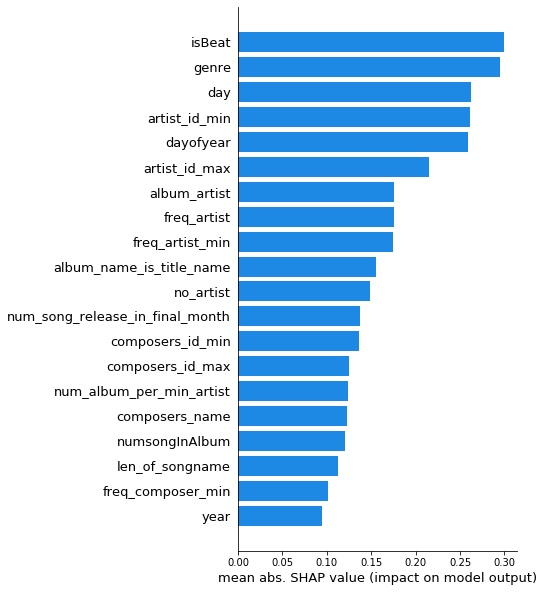

In [15]:
#https://www.kaggle.com/slundberg/interpreting-a-lightgbm-model
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as pl
import gc
import shap
from sklearn.externals import joblib
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test.iloc[:10000,:])

# save model
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
global_importances = np.abs(shap_values).mean(0)[:-1]

# make a bar chart that shows the global importance of the top 20 features
inds = np.argsort(-global_importances)
f = pl.figure(figsize=(5,10))
y_pos = np.arange(20)
inds2 = np.flip(inds[:20], 0)
pl.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
pl.yticks(y_pos, fontsize=13)
pl.gca().set_yticklabels(df_train[best_chosen_features].columns[inds2])
pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('none')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)


In [18]:
explainer = shap.TreeExplainer(clf)

In [169]:
np.sqrt((Y_test-y_pred)**2).mean()

1.2302158072796683

In [91]:
#y_pred =clf.predict(X_test)
rmse = pd.Series(np.sqrt((Y_test-y_pred)**2))
rmse.sort_values(ascending=False).iloc[0:10]

149      7.831751
5682     5.891444
9839     5.685289
9980     5.666557
7416     5.468640
280      5.424291
8596     5.282249
10024    5.274662
8066     5.255569
5559     5.182887
Name: label, dtype: float64

In [104]:
shap.initjs()
index = 149 # series index 
i = X_test.index.get_loc(index)
print("Truth", Y_test.iloc[i], "Prediction:", clf.predict(X_test.iloc[i,:]))
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])


Truth 10.0 Prediction: [2.16824896]


In [92]:
shap.force_plot(explainer.expected_value, shap_values, X_test)


In [154]:
pd.Series(['a','b','c', 'a']).astype('category').cat.codes

0    0
1    1
2    2
3    0
dtype: int8

0          60
1          39
2          36
3          60
4          55
5         260
6          39
8          39
9          29
10         39
11        309
12         86
13        226
14         72
15         12
17         88
18        261
20        129
21        193
22        644
24        104
26         39
27         79
28         19
30         48
31         39
32        226
33        587
35        745
36        706
         ... 
10160     493
10161     493
10162    1362
10164    1465
10165     202
10166     752
10167     752
10168    1157
10169    1758
10170    1758
10171     367
10172    1134
10173    1096
10175    1760
10176     842
10178    1757
10180    1720
10181    1761
10182    1685
10183    1685
10184    1685
10186     467
10187    1446
10188    1763
10189    1763
10191    1763
10192    1763
10193    1763
10194    1763
10195    1465
Name: artist_id_min, Length: 9078, dtype: int16

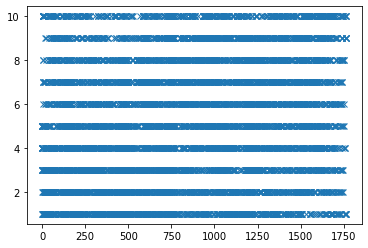

In [142]:
import matplotlib.pyplot as plt 
plt.plot(df_train['artist_id_min'], df_train.label, 'x')
df_train['artist_id_min']

In [131]:

np.where(df['artist_id'].astype('category').cat.codes.values == 0)

df.iloc[1678]

index                                                                     9262
ID                                                                  1076392625
title                                   Khúc Hát Nàng Tiên Cá (The Siren Aria)
artist_name                                                               2278
artist_id                                                               100158
composers_name                                                            1923
composers_id                                                            100158
release_time                                               2017-09-27 22:09:00
label                                                                      NaN
dataset                                                                   test
Unnamed: 0_x                                                              9762
genre                                                                        4
album_artist                                        

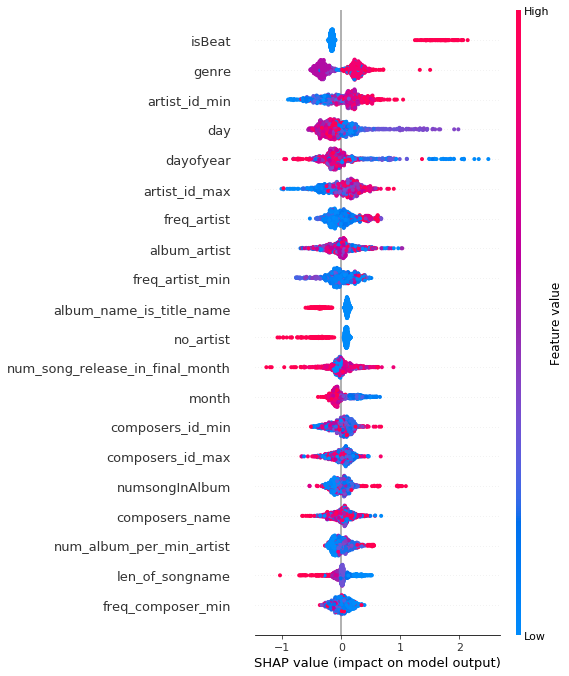

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

ax, fig = plt.subplots()
ax = shap.summary_plot(shap_values, X_test.iloc[:10000,:], show=False)
f = plt.gcf()
f.tight_layout()
f.savefig('summaryplot.pdf')

In [ ]:
shap.dependence_plot("artist_id_min", shap_values, X_test.iloc[:10000,:])

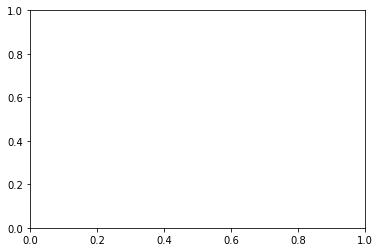

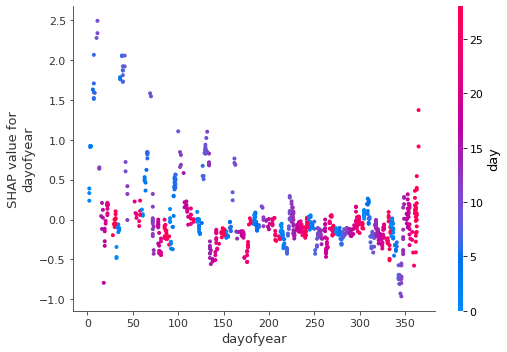

In [165]:

%matplotlib inline
import matplotlib.pyplot as plt

ax, fig = plt.subplots()
shap.dependence_plot("dayofyear", shap_values, X_test.iloc[:10000,:], show=False)
f = plt.gcf()
f.tight_layout()
f.savefig('dayofyear.pdf')

In [157]:
interactions= explainer.shap_interaction_values(X_test.iloc[:10000,:])
shap.summary_plot(shap_interaction_values, X_test.iloc[:10000,:])

NameError: name 'shap_interaction_values' is not defined

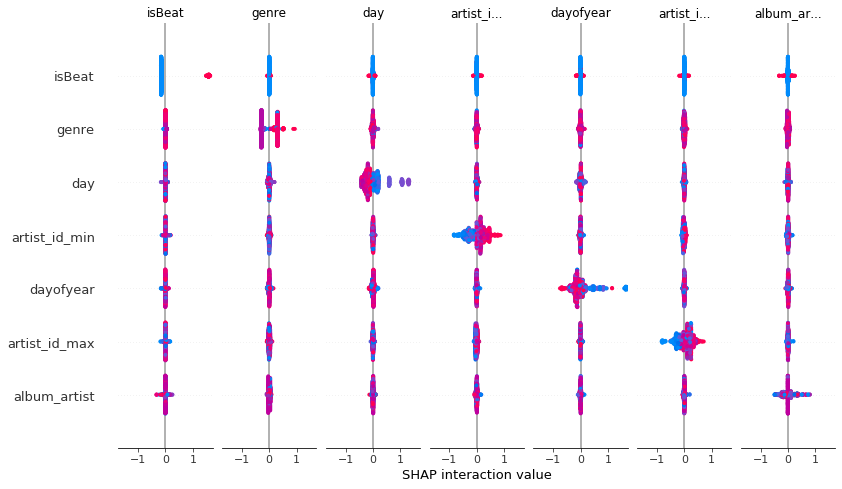

In [158]:
shap.summary_plot(interactions, X_test.iloc[:10000,:])

/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


NameError: name 'df' is not defined

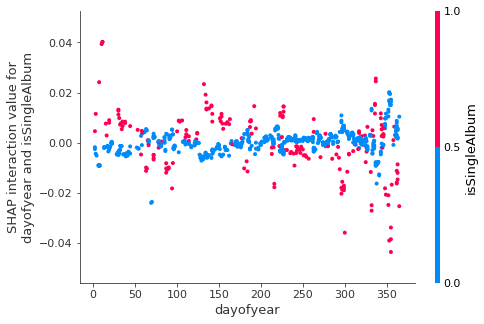

In [166]:
shap.dependence_plot(
    ("dayofyear", "isSingleAlbum"),
    interactions, X_test.iloc[:,:],
   # display_features=X_display.iloc[:2000,:]
)

In [159]:
from joblib import dump, load
dump(shap, 'shap_of_model.dump') 
dump(shap, 'interactions_of_model.dump') 

TypeError: can't pickle module objects

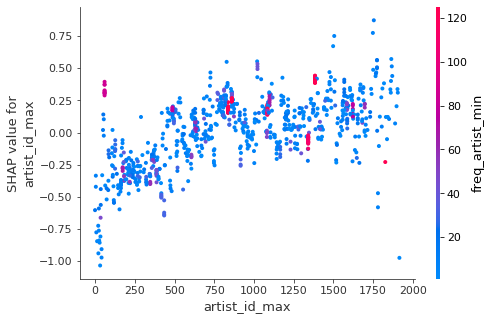

In [105]:
shap.dependence_plot("artist_id_max", shap_values, X_test.iloc[:10000,:])

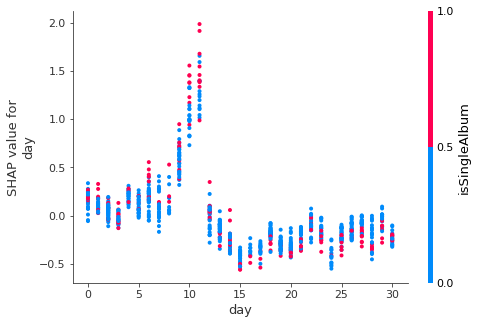

In [41]:
shap.dependence_plot("day", shap_values, X_test.iloc[:10000,:])

In [21]:
from math import sqrt

print("RMSE: {:<8.5f}".format(sqrt(mean_squared_error(df_train.label, oof))))
sub = pd.DataFrame({"ID": df_test.ID.values})
sub["label"] = predictions.round(decimals=4)
sub.to_csv("submission_lightgbm.csv", index=False, header=False)


RMSE: 1.35342 


In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,30))
lgb.plot_importance(clf, max_num_features=20,importance_type='gain')
fig.savefig('exp1.png')

array([7.143 , 6.6055, 7.5288, ..., 3.2008, 7.4618, 9.1933])

<Figure size 2160x2160 with 0 Axes>

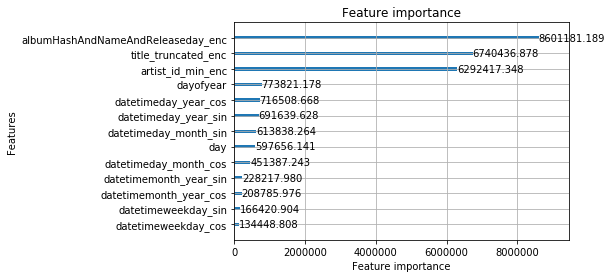